## Step 1

[*********************100%%**********************]  1 of 1 completed

Selected stocks: ['GM', 'SPG', 'MDLZ', 'LNT', 'RF']

Processing GM...



[*********************100%%**********************]  1 of 1 completed


GM basic financial metrics:
Book Value Per Share: $62.12
Earnings Per Share: $9.21
Latest P/B ratio: 0.82
Latest P/E ratio: 5.55
Successfully processed GM

Processing SPG...



[*********************100%%**********************]  1 of 1 completed


SPG basic financial metrics:
Book Value Per Share: $11.30
Earnings Per Share: $7.00
Latest P/B ratio: 15.92
Latest P/E ratio: 25.72
Successfully processed SPG

Processing MDLZ...



[*********************100%%**********************]  1 of 1 completed


MDLZ basic financial metrics:
Book Value Per Share: $21.21
Earnings Per Share: $3.71
Latest P/B ratio: 2.89
Latest P/E ratio: 16.54
Successfully processed MDLZ

Processing LNT...



[*********************100%%**********************]  1 of 1 completed


LNT basic financial metrics:
Book Value Per Share: $26.41
Earnings Per Share: $2.74
Latest P/B ratio: 2.26
Latest P/E ratio: 21.74
Successfully processed LNT

Processing RF...



RF basic financial metrics:
Book Value Per Share: $19.25
Earnings Per Share: $2.28
Latest P/B ratio: 1.28
Latest P/E ratio: 10.78
Successfully processed RF

=== Analysis for GM ===

Descriptive statistics:
       Daily_Returns        MA20        MA50  Volatility_20   Volume_MA20  \
count     492.000000  474.000000  444.000000     473.000000  4.740000e+02   
mean        0.001053   39.831311   39.353395       0.019872  1.524673e+07   
std         0.020663    6.778155    6.156323       0.005173  3.244063e+06   
min        -0.089867   27.969000   29.648800       0.009414  1.056056e+07   
25%        -0.010216   34.544875   34.311000       0.015899  1.310594e+07   
50%         0.001447   38.847000   37.614100       0.019443  1.437824e+07   
75%         0.011702   45.157875   45.794400       0.023145  1.706333e+07   
max         0.098099   56.119000   53.038600       0.031103  2.709996e+07   

              P/B         P/E  
count  493.000000  493.000000  
mean     0.644166    4.344924  
std

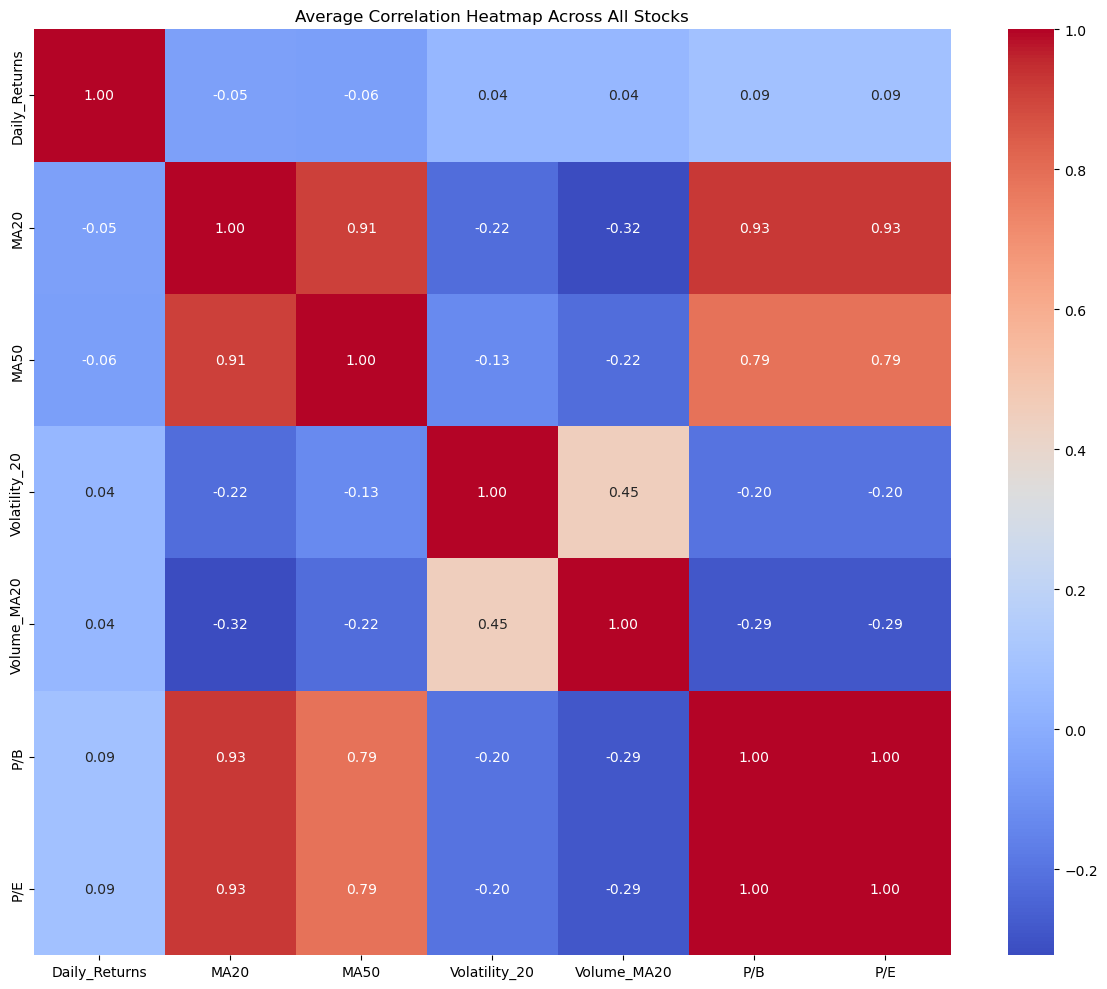

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

# Function to get basic historical metrics
def get_historical_metrics(ticker, start_date='2023-01-01', end_date='2024-12-18'):
    try:
        # Get stock price data
        stock = yf.download(ticker, start=start_date, end=end_date)
        if stock.empty:
            print(f"No data downloaded for {ticker}")
            return pd.DataFrame()
            
        metrics = pd.DataFrame()
        ticker_info = yf.Ticker(ticker)
        
        # Get balance sheet and income statement data
        balance_sheet = ticker_info.balance_sheet
        income_stmt = ticker_info.financials
        
        # Simplified calculations using available fields
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_liabilities = balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
        net_income = income_stmt.loc['Net Income'].iloc[0]
        shares_outstanding = ticker_info.info.get('sharesOutstanding', None)
        
        # Calculate book value and EPS
        book_value = total_assets - total_liabilities
        bvps = book_value / shares_outstanding if shares_outstanding else np.nan
        eps = net_income / shares_outstanding if shares_outstanding else np.nan
            
        # Calculate basic metrics
        metrics['Daily_Returns'] = stock['Close'].pct_change()
        metrics['MA20'] = stock['Close'].rolling(window=20).mean()
        metrics['MA50'] = stock['Close'].rolling(window=50).mean()
        metrics['Volatility_20'] = metrics['Daily_Returns'].rolling(window=20).std()
        metrics['Volume_MA20'] = stock['Volume'].rolling(window=20).mean()
        
        # Calculate P/B and P/E using closing prices
        if bvps > 0:
            metrics['P/B'] = stock['Close'] / bvps
        else:
            metrics['P/B'] = np.nan
            
        if eps > 0:
            metrics['P/E'] = stock['Close'] / eps
        else:
            metrics['P/E'] = np.nan
        
        print(f"\n{ticker} basic financial metrics:")
        print(f"Book Value Per Share: ${bvps:.2f}")
        print(f"Earnings Per Share: ${eps:.2f}")
        if not metrics.empty:
            print(f"Latest P/B ratio: {metrics['P/B'].iloc[-1]:.2f}")
            print(f"Latest P/E ratio: {metrics['P/E'].iloc[-1]:.2f}")
        
        return metrics
        
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return pd.DataFrame()
# Get SP500 components and randomly select stocks
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
selected_stocks = random.sample(sp500['Symbol'].tolist(), 5)

print("Selected stocks:", selected_stocks)

# Collect historical metrics
all_metrics = {}
for ticker in selected_stocks:
    print(f"\nProcessing {ticker}...")
    metrics = get_historical_metrics(ticker)
    if not metrics.empty:
        all_metrics[ticker] = metrics
        print(f"Successfully processed {ticker}")

# Print summary statistics and create visualizations for each stock
for ticker, data in all_metrics.items():
    print(f"\n=== Analysis for {ticker} ===")
    
    # Print basic statistics
    print("\nDescriptive statistics:")
    print(data.describe())
    
    
    # Print autocorrelation statistics
    print("\nAutocorrelation Statistics:")
    for column in data.columns:
        try:
            lb_test = acorr_ljungbox(data[column].dropna(), lags=[10])
            print(f"\n{column}:")
            print(f"Ljung-Box test p-value: {lb_test.iloc[0]['lb_pvalue']:.4f}")
        except Exception as e:
            print(f"Could not calculate Ljung-Box test for {column}: {str(e)}")

# Calculate average metrics across all stocks
print("\n=== Overall Analysis ===")

# Combine correlation matrices
correlation_matrices = [data.corr() for data in all_metrics.values()]
if correlation_matrices:
    avg_correlation = sum(correlation_matrices) / len(correlation_matrices)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(avg_correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Average Correlation Heatmap Across All Stocks')
    plt.tight_layout()
    plt.show()

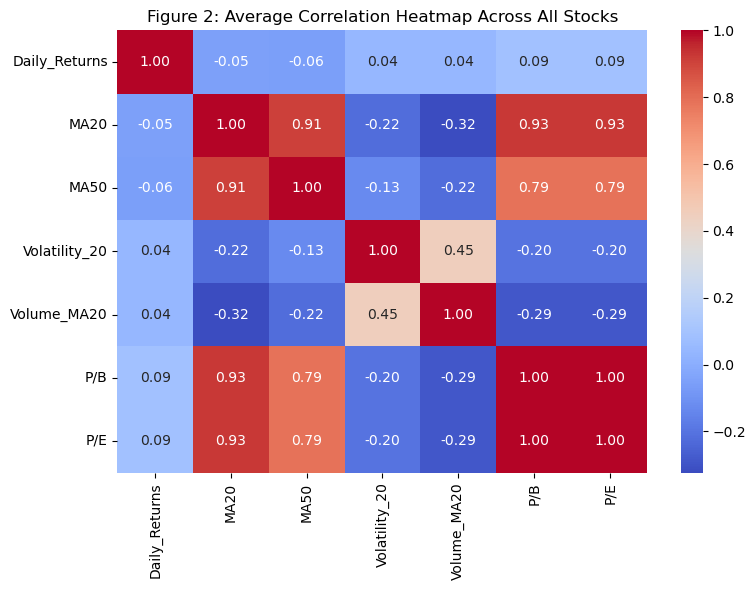

In [8]:
# Combine correlation matrices
correlation_matrices = [data.corr() for data in all_metrics.values()]
if correlation_matrices:
    avg_correlation = sum(correlation_matrices) / len(correlation_matrices)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Figure 2: Average Correlation Heatmap Across All Stocks')
    plt.tight_layout()
    plt.show()

In [10]:
def get_stock_features(ticker):
    try:
        # Get price data and calculate returns
        stock = yf.download(ticker, start='2023-01-01', end='2024-12-18')
        returns = stock['Close'].pct_change()
        
        # Get P/B and P/E ratios
        ticker_info = yf.Ticker(ticker)
        balance_sheet = ticker_info.balance_sheet
        income_stmt = ticker_info.financials
        
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_liabilities = balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
        net_income = income_stmt.loc['Net Income'].iloc[0]
        shares_outstanding = ticker_info.info.get('sharesOutstanding', None)
        
        # Calculate ratios
        book_value = total_assets - total_liabilities
        bvps = book_value / shares_outstanding if shares_outstanding else np.nan
        eps = net_income / shares_outstanding if shares_outstanding else np.nan
        pb_ratio = stock['Close'] / bvps if bvps > 0 else np.nan
        pe_ratio = stock['Close'] / eps if eps > 0 else np.nan
        
        # Create features DataFrame
        features = pd.DataFrame({
            'Returns': returns,
            'P/B': pb_ratio,
            'P/E': pe_ratio,
            'Volatility': returns.rolling(window=20).std(),
        })
        
        return features.dropna()
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None

# Get SP500 index data
sp500_data = yf.download('^GSPC', start='2023-01-01', end='2024-12-18')
sp500_returns = sp500_data['Close'].pct_change()

# Get features for selected stocks
all_features = {}
for ticker in selected_stocks:
    features = get_stock_features(ticker)
    if features is not None:
        all_features[ticker] = features

# Combine all features
combined_features = pd.DataFrame()
for ticker, features in all_features.items():
    for col in features.columns:
        combined_features[f'{ticker}_{col}'] = features[col]

# Remove any NaN values
combined_features = combined_features.dropna()
sp500_returns = sp500_returns[combined_features.index]

# Calculate correlations with SP500
correlations = pd.DataFrame()
correlations['Correlation'] = combined_features.apply(lambda x: x.corr(sp500_returns))
correlations = correlations.sort_values('Correlation', ascending=True)

# Test model with different feature sets
def test_feature_sets():
    # High correlation features (top 25%)
    high_corr_features = correlations.nlargest(len(correlations)//4, 'Correlation').index
    
    # Low correlation features (bottom 75%)
    low_corr_features = correlations.nsmallest(len(correlations)*3//4, 'Correlation').index
    
    # Test scenarios
    scenarios = {
        'High_Corr_Only': high_corr_features,
        'High_Plus_Low': list(high_corr_features) + list(low_corr_features),
    }
    
    results = {}
    for name, features in scenarios.items():
        X = combined_features[features]
        y = sp500_returns
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred)
        }
    
    return results

# Run the test and print results
results = test_feature_sets()
print("\nHypothesis Test Results:")
print("\nHigh Correlation Features Only:")
print(f"R2: {results['High_Corr_Only']['R2']:.4f}")
print(f"MAE: {results['High_Corr_Only']['MAE']:.4f}")

print("\nHigh + Low Correlation Features:")
print(f"R2: {results['High_Plus_Low']['R2']:.4f}")
print(f"MAE: {results['High_Plus_Low']['MAE']:.4f}")

improvement_r2 = results['High_Plus_Low']['R2'] - results['High_Corr_Only']['R2']
improvement_mae = results['High_Corr_Only']['MAE'] - results['High_Plus_Low']['MAE']

print(f"\nImprovement from adding low correlation features:")
print(f"R2 improvement: {improvement_r2:.4f}")
print(f"MAE improvement: {improvement_mae:.4f}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Hypothesis Test Results:

High Correlation Features Only:
R2: 0.3632
MAE: 0.0046

High + Low Correlation Features:
R2: 0.3288
MAE: 0.0046

Improvement from adding low correlation features:
R2 improvement: -0.0344
MAE improvement: -0.0000


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


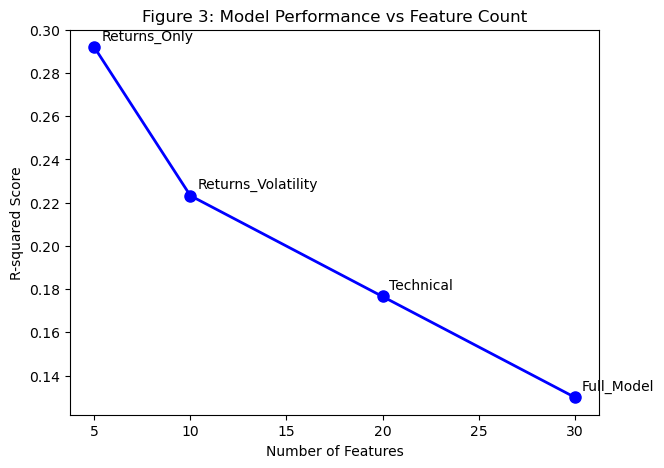

In [13]:
def get_stock_features(ticker):
    try:
        # Get price data
        stock = yf.download(ticker, start='2023-01-01', end='2024-12-18')
        
        # Calculate all features
        features = pd.DataFrame(index=stock.index)
        
        # Level 1: Basic price-based features
        features['Returns'] = stock['Close'].pct_change()
        features['Volatility'] = features['Returns'].rolling(window=20).std()
        features['Volume_Change'] = stock['Volume'].pct_change()
        
        # Level 2: Technical indicators
        features['MA20'] = stock['Close'].rolling(window=20).mean()
        features['MA50'] = stock['Close'].rolling(window=50).mean()
        
        # Level 3: Fundamental ratios
        ticker_info = yf.Ticker(ticker)
        balance_sheet = ticker_info.balance_sheet
        income_stmt = ticker_info.financials
        
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_liabilities = balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
        net_income = income_stmt.loc['Net Income'].iloc[0]
        shares_outstanding = ticker_info.info.get('sharesOutstanding', None)
        
        if shares_outstanding and shares_outstanding > 0:
            book_value = total_assets - total_liabilities
            bvps = book_value / shares_outstanding
            eps = net_income / shares_outstanding
            features['P/B'] = stock['Close'] / bvps
            features['P/E'] = stock['Close'] / eps
        
        return features.dropna()
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return None

# Get SP500 data
sp500_data = yf.download('^GSPC', start='2023-01-01', end='2024-12-18')
sp500_returns = sp500_data['Close'].pct_change()

# Get features for selected stocks
all_features = {}
for ticker in selected_stocks:
    features = get_stock_features(ticker)
    if features is not None:
        all_features[ticker] = features

# Combine all features
combined_features = pd.DataFrame()
for ticker, features in all_features.items():
    for col in features.columns:
        combined_features[f'{ticker}_{col}'] = features[col]

# Remove any NaN values
combined_features = combined_features.dropna()
sp500_returns = sp500_returns[combined_features.index]

def test_feature_sets():
    results = []
    
    # Test different numbers of features
    feature_groups = []
    
    # Start with basic features (returns only)
    returns_features = [col for col in combined_features.columns if 'Returns' in col]
    feature_groups.append(('Returns_Only', returns_features))
    
    # Add volatility features
    vol_features = returns_features + [col for col in combined_features.columns if 'Volatility' in col]
    feature_groups.append(('Returns_Volatility', vol_features))
    
    # Add technical indicators
    tech_features = vol_features + [col for col in combined_features.columns if 'MA' in col]
    feature_groups.append(('Technical', tech_features))
    
    # Add fundamental ratios
    fund_features = tech_features + [col for col in combined_features.columns if 'P/B' in col or 'P/E' in col]
    feature_groups.append(('Full_Model', fund_features))
    
    for name, features in feature_groups:
        X = combined_features[features]
        y = sp500_returns
        
        # Calculate average feature correlation
        corr_matrix = X.corr().abs()
        avg_corr = (corr_matrix.sum().sum() - len(corr_matrix)) / (len(corr_matrix)**2 - len(corr_matrix))
        
        # Test model performance
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results.append({
            'Model': name,
            'Num_Features': len(features),
            'R2': r2_score(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'Avg_Correlation': avg_corr
        })
    
    return pd.DataFrame(results)

# Run analysis
results_df = test_feature_sets()

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Performance vs Number of Features
plt.subplot(1, 2, 1)
plt.plot(results_df['Num_Features'], results_df['R2'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Features')
plt.ylabel('R-squared Score')
plt.title('Figure 3: Model Performance vs Feature Count')
for i, txt in enumerate(results_df['Model']):
    plt.annotate(txt, (results_df['Num_Features'].iloc[i], results_df['R2'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points')



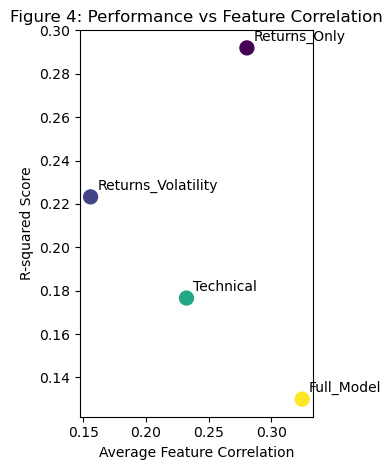


Detailed Results:
                Model  Num_Features      R2     MAE  Avg_Correlation
0        Returns_Only             5  0.2919  0.0048           0.2806
1  Returns_Volatility            10  0.2233  0.0051           0.1558
2           Technical            20  0.1766  0.0052           0.2324
3          Full_Model            30  0.1300  0.0053           0.3247


In [14]:
# Plot 2: Performance vs Average Feature Correlation
plt.subplot(1, 2, 2)
plt.scatter(results_df['Avg_Correlation'], results_df['R2'], c=results_df['Num_Features'], 
           cmap='viridis', s=100)
plt.xlabel('Average Feature Correlation')
plt.ylabel('R-squared Score')
plt.title('Figure 4: Performance vs Feature Correlation')
for i, txt in enumerate(results_df['Model']):
    plt.annotate(txt, (results_df['Avg_Correlation'].iloc[i], results_df['R2'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Print numerical results
print("\nDetailed Results:")
print(results_df.round(4))